# Keras mnist  LeNet-5 v2
**此项目为测试修改版的LeNet-5，并且使用图像增强，调节学习率**
- 目前能在测试集上达到$0.9952$的准确率

In [1]:
%matplotlib inline
import os
import PIL
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from IPython import display
from functools import partial
from sklearn.preprocessing import normalize

from keras import backend
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Input, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, BatchNormalization

import warnings 
warnings.filterwarnings('ignore')
np.random.seed(42)

Using TensorFlow backend.


## 准备数据

In [2]:
file_path = r"I:\Dataset\mnist\all_mnist_data.csv"
mnist_data = pd.read_csv(file_path)

idx = np.random.permutation(len(mnist_data))
train_data = mnist_data.iloc[idx[: 60000]]
test_data = mnist_data.iloc[idx[60000: ]]

X_train = np.array(train_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")
X_test  = np.array(test_data.drop('0', axis=1)).reshape(-1, 28, 28, 1).astype("float32")

y_train = np.array(train_data['0'])
y_test  = np.array(test_data['0'])
y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)

x_train = X_train[10000:]
t_train = y_train[10000:]
x_val   = X_train[:10000]
t_val   = y_train[:10000]

print("\nimgs   of trainset : ", x_train.shape)
print("labels of trainset : ", t_train.shape)
print("imgs   of   valset : ", x_val.shape)
print("labels of   valset : ", t_val.shape)
print("imgs   of  testset : ", X_test.shape)
print("labels of  testset : ", y_test.shape)


imgs   of trainset :  (50000, 28, 28, 1)
labels of trainset :  (50000, 10)
imgs   of   valset :  (10000, 28, 28, 1)
labels of   valset :  (10000, 10)
imgs   of  testset :  (10000, 28, 28, 1)
labels of  testset :  (10000, 10)


## 搭建模型

In [3]:
def myCNN():
    model = Sequential()

    model.add(Conv2D(filters=16,
                     kernel_size=(5, 5),
                     padding='same',
                     input_shape=(28, 28, 1),
                     activation='relu',
                     name='conv2d_1'))

    model.add(MaxPool2D(pool_size=(2, 2), name='max_pool2d_1'))

    model.add(Conv2D(filters=36,
                     kernel_size=(5, 5),
                     padding='same',
                     input_shape=(14, 14, 1),
                     activation='relu',
                     name='conv2d_2'))

    model.add(MaxPool2D(pool_size=(2, 2), name='max_pool2d_2'))

    model.add(Dropout(0.25, name='dropout_1'))

    model.add(Flatten(name='flatten_1'))

    model.add(Dense(128, activation='relu', name='dense_1'))
    model.add(Dropout(0.5, name='dropout_2'))

    model.add(Dense(10, activation='softmax', name='dense_2'))
    return model
model = myCNN()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        416       
_________________________________________________________________
max_pool2d_1 (MaxPooling2D)  (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pool2d_2 (MaxPooling2D)  (None, 7, 7, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1764)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               225920    
__________

### 分配计算资源

In [4]:
# 设置每个进程占用gpu内存的30%，方便同时进行其他任务
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
sess = tf.Session(config=config)
backend.set_session(sess)

### 训练

In [5]:
"""训练模型并保存模型及训练历史
保存模型单独创建一个子文件夹modeldir, 保存训练历史则为单个文件hisfile"""

models_name = "Keras_mnist_LeNet-5_DA_lr" # 模型名称的公共前缀
factor_list = [""] # 此次调参的变量列表

model_list = []      # 模型名称列表
for i in range(len(factor_list)):
    modelname = models_name + factor_list[i] + ".h5"
    model_list.append(modelname)

# 创建模型保存子目录modeldir
if not os.path.isdir("saved_models"): 
    os.mkdir("saved_models")
modeldir = r"saved_models"

# 创建训练历史保存目录
if not os.path.isdir("train_history"): 
    os.mkdir("train_history")
# 设置训练历史文件路径
hisfile = r"train_history\Keras_mnist_LeNet-5_DA_lr.train_history" 
# 每个模型及其对应的训练历史作为键值对{modelname: train_history}
# train_history为字典，含四个key，代表train和val的loss和acc
model_train_history = dict() 


# 开始训练
epochs=100
batch_size = 32
steps_per_epoch=1250
for i in range(len(model_list)):
    model = myCNN()
    modelname = model_list[i]
    modelpath = os.path.join(modeldir, modelname)    
    
    train_his = np.array([]).reshape(-1, 2)
    val_his = np.array([]).reshape(-1, 2)
    datagen = ImageDataGenerator(  rotation_range=10, 
                                   height_shift_range=0.1, 
                                   width_shift_range=0.1,
                                   fill_mode="constant",
                                   cval=0.0,)
    datagen.fit(x_train)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=keras.optimizers.Adam(),
                  metrics=["accuracy"])
    print("\ntraining model : ", modelname)
    
    lr = 0.001
    ck_epoch, max_val_acc = 0, 0.0
    for epoch in range(epochs+1):
        i = 0
        tr_his = []
        for X, y in datagen.flow(x_train, t_train, batch_size=batch_size):
            his = model.train_on_batch(X, y)
            tr_his.append(his)
            i += 1
            if i >= steps_per_epoch: break
        tr = np.mean(tr_his, axis=0)
        val = model.evaluate(x_val, t_val, verbose=0)
        train_his = np.vstack((train_his, tr))
        val_his = np.vstack((val_his, val))
        if epoch%5==0:
            print("%4d epoch: train acc: %8f loss: %8f      val acc: %8f loss: %8f"%(epoch, tr[1], tr[0], val[1], val[0]))
        # 设置保存模型
        if val[1] > max_val_acc: 
            model.save(modelpath)
            print("val acc improved from %6f to %6f"%(max_val_acc, val[1]))
            max_val_acc = val[1]
            ck_epoch = epoch
        # 调学习率: 当连续10周期性能没有提升
        if epoch-ck_epoch>10 and lr > 1e-4:
            lr = lr*0.5
            ck_epoch = epoch
            model.compile(loss="categorical_crossentropy", 
                          optimizer=keras.optimizers.Adam(lr=lr),
                          metrics=["accuracy"])
            print("lr : ", lr)
    model_train_history[modelname] = {"acc": train_his[:, 1], "val_acc": val_his[:, 1],
                                      "loss": train_his[:, 0], "val_loss": val_his[:, 0]}

"""保存训练历史"""
fo = open(hisfile, 'wb')
pickle.dump(model_train_history, fo)
fo.close() 


training model :  Keras_mnist_LeNet-5_DA_lr.h5
   0 epoch: train acc: 0.872950 loss: 0.403003      val acc: 0.977100 loss: 0.075597
val acc improved from 0.000000 to 0.977100
val acc improved from 0.977100 to 0.982400
val acc improved from 0.982400 to 0.983000
val acc improved from 0.983000 to 0.987100
val acc improved from 0.987100 to 0.989100
   5 epoch: train acc: 0.974900 loss: 0.084882      val acc: 0.987200 loss: 0.037851
  10 epoch: train acc: 0.982125 loss: 0.060218      val acc: 0.988800 loss: 0.035363
val acc improved from 0.989100 to 0.989500
val acc improved from 0.989500 to 0.990300
val acc improved from 0.990300 to 0.992100
  15 epoch: train acc: 0.985250 loss: 0.051404      val acc: 0.991800 loss: 0.026642
  20 epoch: train acc: 0.985900 loss: 0.048123      val acc: 0.991400 loss: 0.029014
val acc improved from 0.992100 to 0.992500
val acc improved from 0.992500 to 0.992900
  25 epoch: train acc: 0.987675 loss: 0.045439      val acc: 0.992000 loss: 0.027855
  30 epoch: 

### 可视化训练过程

In [6]:
def show_train_history(saved_history, his_img_file):  
    modelnames = sorted(list(saved_history.keys()))
    train = ["acc", "loss"]
    val = ["val_acc", "val_loss"]
    
    """作loss和acc两个图"""
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax = ax.flatten()
    color_add = 0.9/len(saved_history)
    for i in range(2):
        c = 0.05
        for j in range(len(saved_history)):
            modelname = modelnames[j]
            train_history = saved_history[modelname]
            ax[i].plot(train_history[train[i]], 
                       color=(0, 1-c, 0),
                       linestyle="-",
                       label="train_"+modelname[21:-3])
            ax[i].plot(train_history[val[i]], 
                       color=(c, 0, 1-c),
                       linestyle="-",
                       label="val_"+modelname[21:-3])
            c += color_add
        ax[i].set_title('Train History')
        ax[i].set_ylabel(train[i])  
        ax[i].set_xlabel('Epoch')  
    ax[0].legend(loc="lower right")
    ax[1].legend(loc="upper right") 
    ax[0].set_ylim(0.9, 1.0)
    ax[1].set_ylim(0, 0.2)
    plt.suptitle("LeNet-5_DA_lr")
    
    print("saved img: ", his_img_file)
    plt.savefig(his_img_file)
    plt.show()

saved img:  his_img\LeNet-5_DA_lr.png


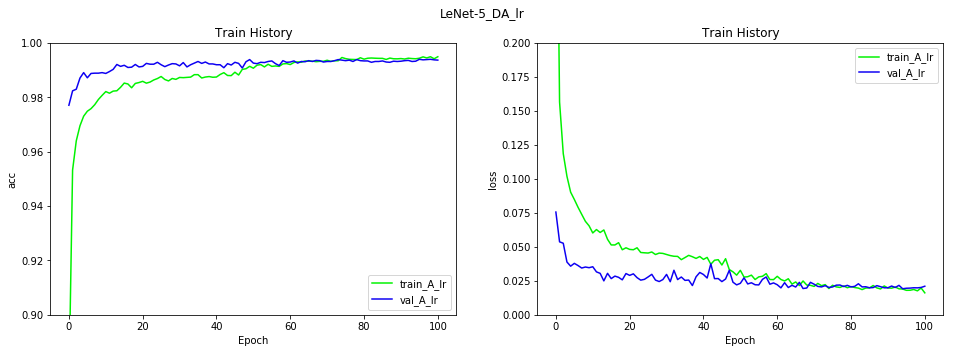

In [7]:
"""载入训练历史并可视化, 并且保存图片"""
if not os.path.isdir("his_img"):
    os.mkdir("his_img")
his_img_file = r"his_img\LeNet-5_DA_lr.png"

fo2 = open(hisfile, "rb")
saved_history1 = pickle.load(fo2)

show_train_history(saved_history1, his_img_file)

## 在测试集上测试

In [8]:
smodel = load_model(modelpath)

print("test model: ", os.path.basename(modelpath))
loss, acc = smodel.evaluate(X_test, y_test)
print("test ：acc: %.4f"%(acc))

test model:  Keras_mnist_LeNet-5_DA_lr.h5
10000/10000 [==============================] - 8s 826us/step
test ：acc: 0.9952
